In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

In [16]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
sns.set_style("ticks")

In [17]:
data = pd.read_csv('/home/steve/Documents/ENSAE/Projet_ML_Tennis/Data/tennis_atp-master/atp_matches_2010.csv')
for annee in range(2000, 2020):
    data = pd.concat([data, pd.read_csv('/home/steve/Documents/ENSAE/Projet_ML_Tennis/Data/tennis_atp-master/atp_matches_'+str(annee)+'.csv')], axis=0)

In [18]:
data['tourney_date'] = pd.to_datetime(data['tourney_date'], yearfirst=True, format='%Y%m%d')

In [19]:
data = data[~data['tourney_name'].str.startswith('Davis Cup')].copy()
data.dropna(subset=['minutes'], inplace=True)

In [20]:
data = data[~data['score'].str.contains('RET')].copy()
#On enlève les lignes des matchs gagné/perdu par abandon de l'adversaire car ils sont un biais à notre analyse

In [22]:
data.drop_duplicates(inplace=True)

In [21]:
data['year'] = data['tourney_date'].apply(lambda x: x.year)

### Corrections
En étudiant les valeurs extrêmes de notre jeu de données nous avons constaté la présence de quelques erreurs concernant la durée de certains matchs. Nous avons constaté que trois matchs étaient anormalement long. Sur les trois, deux étaient en effet des erreurs de saisis cependant, le troisième correspond au match de Wimbledon (2010) entre Josh Ishner et Nicolas Mahut qui a duré 11h05 s'étalant sur trois jours. On notera que John Ishner est un habitué des longs matchs avec 3 apparitions dans le top 10 des plus longs matchs de l'histoire du tennis.

In [26]:
data[(data['tourney_id']=='2017-0308')&(data['match_num']==297)]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
1257,2017-0308,Munich,Clay,32,A,2017-05-01,297,111202,NaN,NaN,Hyeon Chung,R,NaN,KOR,20.950034,105373,NaN,NaN,Martin Klizan,L,190.0,SVK,27.805613,6-4 3-6 6-2,3,QF,98.0,4.0,2.0,81.0,47.0,36.0,15.0,13.0,4.0,6.0,8.0,4.0,95.0,49.0,28.0,27.0,14.0,8.0,12.0,78.0,659.0,53.0,880.0,2017


In [25]:
data.at[1257, 'minutes'] = 98

In [27]:
data[(data['tourney_id']=='2016-M001')&(data['match_num']==294)]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
132,2016-M001,Sydney,Hard,32,A,2016-01-11,294,104180,NaN,NaN,Gilles Muller,L,193.0,LUX,32.676249,104871,6,NaN,Jeremy Chardy,R,188.0,FRA,28.911704,7-6(5) 6-3,3,QF,1146.0,14.0,5.0,59.0,35.0,32.0,13.0,10.0,0.0,0.0,2.0,5.0,69.0,44.0,34.0,10.0,11.0,1.0,3.0,38.0,1105.0,31.0,1255.0,2016


In [28]:
data.at[132, 'minutes'] = 90

## Etudes marcoscopique de ce qui influe sur la durée d'un match de tennis

Tout d'abord nous pouvons nous demander quels sont les facteurs qui influent le plsu sur la durée d'un match de tennis. <br>
Liste résumant ces points : <br>
1) Le nombre de sets nécessaires pour gagner le match (best of 3 / best of 5) <br>
2) La surface sur laquelle ce joue le match (clay / hard / grass / carpet) <br>
3) Le type de tournois (Grand Slam / Master / Other / Challenger / Satellite) <br>
4) Le niveau du tournois du match (32eme / 16eme / 8eme ...) <br>
5) La différence de ranking entre les deux joueurs <br> 
6) Le ranking moyen des deux joueurs (est ce que les joueurs de meilleur niveau on tendance à jouer plus rapidement ou non ?)

In [162]:
data.groupby(['best_of'])['minutes'].mean()

best_of
3     96.587299
5    148.566057
Name: minutes, dtype: float64

In [ ]:
avg_best_of_3_all = data.groupby(['best_of'])['minutes'].mean()[3]

In [163]:
avg_best_of_5_all = data.groupby(['best_of'])['minutes'].mean()[5]

### La surface du terrain

In [75]:
colormap = plt.get_cmap('Set1')

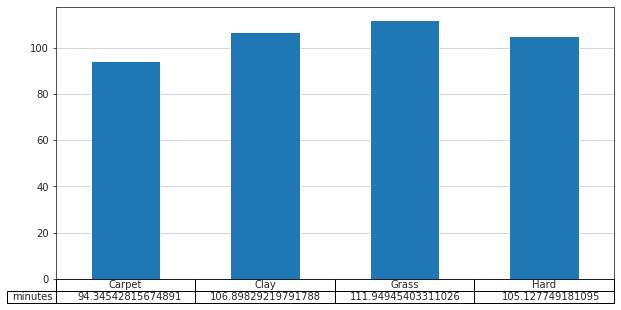

In [87]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['surface'])['minutes'].mean().plot(kind='bar',figsize=(10,5), table=True, grid=True)

Ici on voit que les matchs sur gazon (Grass) on tendance à être plus long que sur les autres surface. Cependant ce résultat est contre intuitif. En effet, il est connu que la surface où la balle va la plus vite et offrant le moins de rebond est le gazon. Il est serait donc normal que les matchs les plus court est lieu sur cette surface.<br><br>
Nous allons affiner l'analyse en séparant les matchs best_of_3 des matchs best_of_5.

In [100]:
data.groupby(['best_of', 'surface'])['match_num'].count().unstack()

surface,Carpet,Clay,Grass,Hard
best_of,,,,
3,1364,14614,3353,23029
5,14,2484,2325,4752


On s'aperçoit que le ratio de match best_of_3/best_of_5 est proche de 1 pour le gazon tandis que sur les autres surfaces il y beaucoup plus de matchs en 3 que en 5. Ceci explique que nla moyenne globale de la durée des matchs sur gazons soit plus élevées que sur les autres matières. <br>
Afin de ne pas biaiser la suite de notre analyse, nous veillerons à toujours séparer ces deux catégories. 

In [77]:
data.groupby(['best_of', 'surface'])['minutes'].mean()

best_of  surface
3        Carpet      93.687683
         Clay        99.278090
         Grass       90.797197
         Hard        95.894524
5        Carpet     158.428571
         Clay       151.729871
         Grass      142.454194
         Hard       149.873527
Name: minutes, dtype: float64

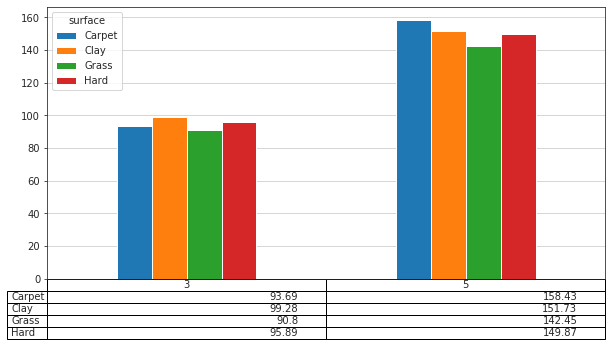

In [97]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'surface'])['minutes'].mean().unstack().plot(kind='bar', figsize=(10,5),
                                                                      table=np.round(data.groupby(['best_of', 'surface'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax)

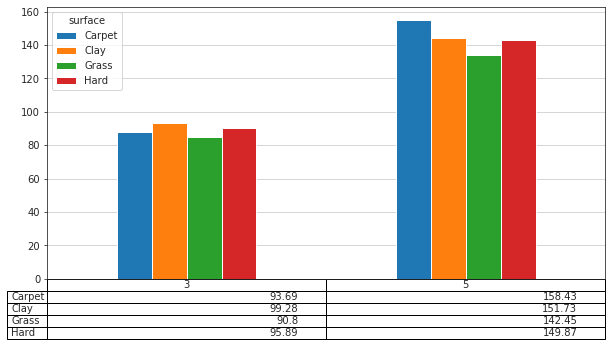

In [101]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'surface'])['minutes'].median().unstack().plot(kind='bar', figsize=(10,5),
                                                                      table=np.round(data.groupby(['best_of', 'surface'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax)

On voit ici qu'en effet la surface al plus rapide est le gazon et la plus lente est la terre battue ou la moquette. 

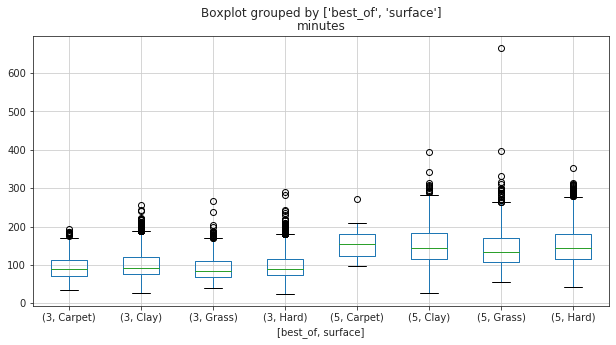

In [50]:
data.boxplot(column=['minutes'], by=['best_of', 'surface'], figsize=(10,5))

In [54]:
data.groupby(['best_of', 'surface'])['match_num'].count()

best_of  surface
3        Carpet      1364
         Clay       14614
         Grass       3353
         Hard       23029
5        Carpet        14
         Clay        2484
         Grass       2325
         Hard        4752
Name: match_num, dtype: int64

### Le type de tournois 

The different tournament tiers are represented by single letters: 'G' = Grand Slams, 'M' = Masters 100s, 'A' = other tour-level events, 'C' = Challengers, 'S' = Satellites/ITFs, 'F' = Tour finals and other season-ending events

In [105]:
data.groupby(['best_of', 'tourney_level'])['minutes'].mean().unstack()

tourney_level,A,F,G,M
best_of,,,,
3,95.670339,104.233577,NaN,99.088219
5,153.425532,148.142857,148.489925,160.380952


In [106]:
data.groupby(['best_of', 'tourney_level'])['minutes'].median().unstack()

tourney_level,A,F,G,M
best_of,,,,
3,90.0,98.0,NaN,93.0
5,143.0,115.0,141.0,140.5


In [107]:
data.groupby(['best_of', 'tourney_level'])['minutes'].describe()

count        mean        std   min     25%    50%  \
best_of tourney_level                                                        
3       A              31408.0   95.670339  29.790703  25.0   72.00   90.0   
        F                274.0  104.233577  32.273956  50.0   77.25   98.0   
        M              10678.0   99.088219  30.595468  28.0   75.00   93.0   
5       A                 47.0  153.425532  54.561391  26.0  118.50  143.0   
        F                  7.0  148.142857  72.792922  96.0   98.00  115.0   
        G               9479.0  148.489925  46.043115  43.0  113.00  141.0   
        M                 42.0  160.380952  54.725012  93.0  120.25  140.5   

                         75%    max  
best_of tourney_level                
3       A              115.0  289.0  
        F              127.0  218.0  
        M              120.0  244.0  
5       A              183.5  300.0  
        F              178.5  273.0  
        G              179.0  665.0  
        M              188.0  314.0

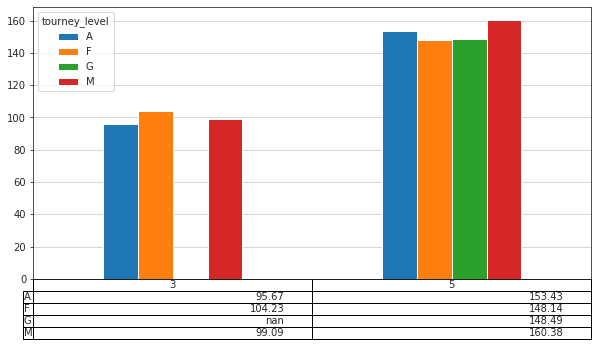

In [110]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'tourney_level'])['minutes'].mean().unstack().plot(kind='bar', figsize=(10,5),
                                                                      table=np.round(data.groupby(['best_of', 'tourney_level'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax)

### Le round

In [113]:
data.groupby(['best_of', 'round'])['minutes'].mean().unstack()

round,BR,ER,F,QF,R128,R16,R32,R64,RR,SF
best_of,,,,,,,,,,
3,138.0,85.96875,104.603232,98.773885,98.376799,97.028406,94.840974,95.375176,99.375899,101.408390
5,NaN,NaN,166.935673,159.401338,145.301574,156.234609,150.541039,148.338629,52.000000,167.302632


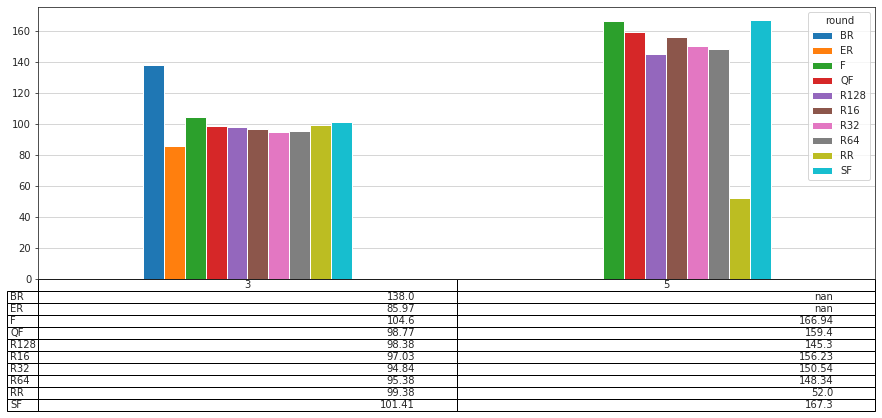

In [115]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'round'])['minutes'].mean().unstack().plot(kind='bar', figsize=(15,5),
                                                                      table=np.round(data.groupby(['best_of', 'round'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax)

### La différence de ranking entre les deux joueurs

In [118]:
data['diff_ranking'] = data.apply(lambda x: abs(x.winner_rank - x.loser_rank), axis=1)

In [124]:
data['diff_ranking'].describe()

count    51785.000000
mean        71.762673
std        111.804257
min          1.000000
25%         19.000000
50%         41.000000
75%         79.000000
max       2125.000000
Name: diff_ranking, dtype: float64

In [121]:
data[data['diff_ranking']==2125]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year,diff_ranking
65,2014-451,Doha,Hard,32,A,2013-12-30,12,104918,3,NaN,Andy Murray,R,190.0,GBR,26.628337,110476,NaN,WC,Mousa Shanan Zayed,U,NaN,QAT,19.811088,6-0 6-0,3,R32,37.0,3.0,3.0,32.0,20.0,20.0,4.0,6.0,0.0,0.0,0.0,2.0,34.0,16.0,4.0,5.0,6.0,3.0,9.0,4.0,5790.0,2129.0,1.0,2013,2125.0


In [129]:
data[data['diff_ranking']>79]['diff_ranking'].describe()

count    12945.000000
mean       191.004789
std        172.284848
min         80.000000
25%         98.000000
50%        130.000000
75%        206.000000
max       2125.000000
Name: diff_ranking, dtype: float64

In [131]:
data[data['diff_ranking']>206]['diff_ranking'].describe()

count    3212.000000
mean      404.028331
std       236.297687
min       207.000000
25%       247.000000
50%       319.000000
75%       466.000000
max      2125.000000
Name: diff_ranking, dtype: float64

In [132]:
data[data['diff_ranking']>466]['diff_ranking'].describe()

count     799.000000
mean      730.785982
std       259.626603
min       467.000000
25%       530.000000
50%       653.000000
75%       848.500000
max      2125.000000
Name: diff_ranking, dtype: float64

In [133]:
data[data['diff_ranking']>1000]['diff_ranking'].describe()

count     112.000000
mean     1232.473214
std       231.337979
min      1002.000000
25%      1061.250000
50%      1167.500000
75%      1334.250000
max      2125.000000
Name: diff_ranking, dtype: float64

In [135]:
data['diff_ranking_categories'] = pd.cut(data['diff_ranking'], [0,20,50,79,206,466,1000,3000])

In [137]:
data.groupby(['best_of', 'diff_ranking_categories'])['minutes'].mean().unstack()

diff_ranking_categories,"(0, 20]","(20, 50]","(50, 79]","(79, 206]","(206, 466]","(466, 1000]","(1000, 3000]"
best_of,,,,,,,
3,98.836543,97.228690,95.971458,94.816253,92.680059,87.388797,75.806122
5,157.525704,151.066278,144.989856,142.515855,134.129032,136.212500,134.071429


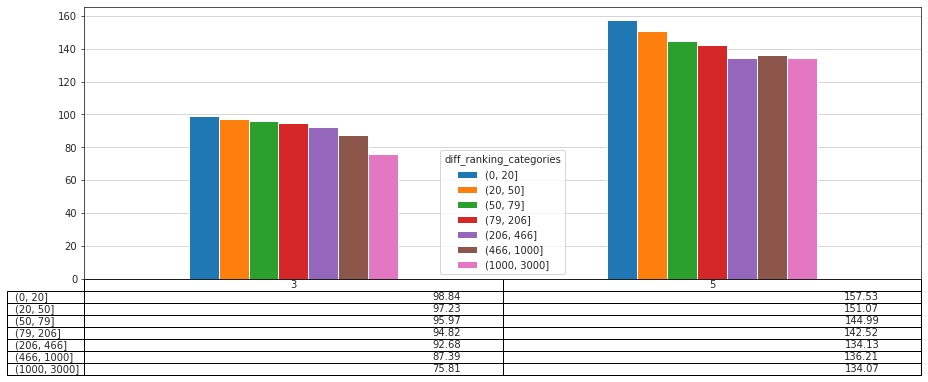

In [138]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'diff_ranking_categories'])['minutes'].mean().unstack().plot(kind='bar', figsize=(15,5),
                                                                      table=np.round(data.groupby(['best_of', 'diff_ranking_categories'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax)

In [142]:
data[['minutes', 'diff_ranking']].corr()

,minutes,diff_ranking
minutes,1.00000,-0.06495
diff_ranking,-0.06495,1.00000


### Ranking moyen 

In [143]:
data['avg_ranking'] = data.apply(lambda x: (x.winner_rank + x.loser_rank)/2, axis=1)

In [144]:
data['avg_ranking'].describe()

count    51785.000000
mean        75.294043
std         71.749463
min          1.500000
25%         35.500000
50%         58.500000
75%         90.500000
max       1484.000000
Name: avg_ranking, dtype: float64

In [146]:
data[data['avg_ranking']>90]['avg_ranking'].describe()

count    12954.000000
mean       160.103713
std         97.479712
min         90.500000
25%        104.000000
50%        126.000000
75%        174.500000
max       1484.000000
Name: avg_ranking, dtype: float64

In [147]:
data[data['avg_ranking']>174]['avg_ranking'].describe()

count    3250.000000
mean      282.841538
std       127.572392
min       174.500000
25%       198.500000
50%       238.500000
75%       316.000000
max      1484.000000
Name: avg_ranking, dtype: float64

In [148]:
data[data['avg_ranking']>376]['avg_ranking'].describe()

count     501.000000
mean      526.507984
std       141.386795
min       376.500000
25%       424.500000
50%       491.000000
75%       578.500000
max      1484.000000
Name: avg_ranking, dtype: float64

In [149]:
data['avg_ranking_categories'] = pd.cut(data['avg_ranking'], [0,35,60,90,125,240,500,1500])

In [150]:
data.groupby(['best_of', 'avg_ranking_categories'])['minutes'].mean().unstack()

avg_ranking_categories,"(0, 35]","(35, 60]","(60, 90]","(90, 125]","(125, 240]","(240, 500]","(500, 1500]"
best_of,,,,,,,
3,99.613577,97.021949,95.629561,95.283792,94.519148,91.453125,83.309859
5,155.473852,146.190528,146.966418,144.884354,147.176179,136.335714,146.916667


In [152]:
data[['minutes', 'avg_ranking']].corr()

,minutes,avg_ranking
minutes,1.000000,-0.079833
avg_ranking,-0.079833,1.000000


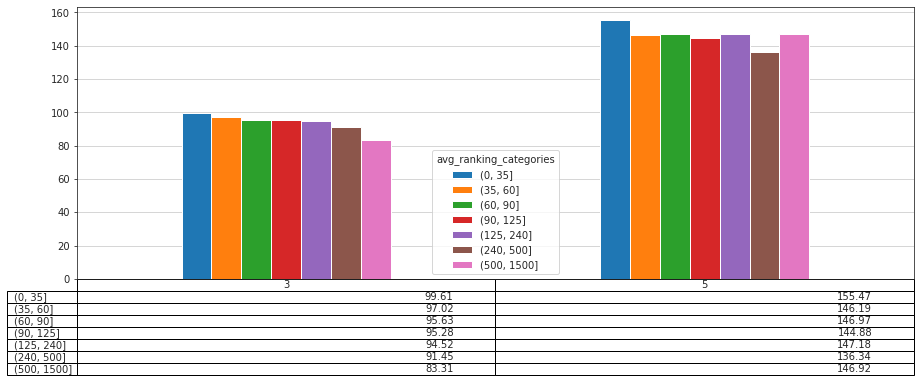

In [153]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'avg_ranking_categories'])['minutes'].mean().unstack().plot(kind='bar', figsize=(15,5),
                                                                      table=np.round(data.groupby(['best_of', 'avg_ranking_categories'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax)

### Analyse du top 500 des matchs les plus rapides

In [173]:
top_500_rapides = data.nsmallest(500, 'minutes')

In [169]:
top_500_rapides.groupby('best_of')[['minutes', 'winner_rank', 'loser_rank', 'diff_ranking', 'avg_ranking']].describe().transpose()

best_of                       3           5
minutes      count   498.000000    2.000000
             mean     45.130522   34.500000
             std       3.928054   12.020815
             min      25.000000   26.000000
             25%      44.000000   30.250000
             50%      46.000000   34.500000
             75%      48.000000   38.750000
             max      49.000000   43.000000
winner_rank  count   498.000000    2.000000
             mean     69.208835   60.000000
             std      88.403960   66.468037
             min       1.000000   13.000000
             25%      23.000000   36.500000
             50%      47.000000   60.000000
             75%      87.750000   83.500000
             max    1076.000000  107.000000
loser_rank   count   480.000000    2.000000
             mean    154.862500  142.000000
             std     264.372377   82.024387
             min       1.000000   84.000000
             25%      57.000000  113.000000
             50%      85.000000  142.000000
             75%     123.250000  171.000000
             max    2159.000000  200.000000
diff_ranking count   480.000000    2.000000
             mean    127.379167  105.000000
             std     264.593962  115.965512
             min       1.000000   23.000000
             25%      23.000000   64.000000
             50%      50.000000  105.000000
             75%      98.250000  146.000000
             max    2125.000000  187.000000
avg_ranking  count   480.000000    2.000000
             mean    111.091667  101.000000
             std     137.630936    7.778175
             min       5.500000   95.500000
             25%      49.875000   98.250000
             50%      70.250000  101.000000
             75%     107.500000  103.750000
             max    1114.000000  106.500000

###  Analyse du top 500 des matchs les plus lents

In [171]:
top_500_lents = data.nlargest(500, 'minutes')

In [172]:
top_500_lents.groupby('best_of')[['minutes', 'winner_rank', 'loser_rank', 'diff_ranking', 'avg_ranking']].describe().transpose()

best_of                      3            5
minutes      count   10.000000   490.000000
             mean   253.300000   256.714286
             std     19.402463    28.946393
             min    235.000000   232.000000
             25%    240.250000   239.000000
             50%    243.500000   251.000000
             75%    263.500000   266.000000
             max    289.000000   665.000000
winner_rank  count   10.000000   490.000000
             mean    27.200000    55.781633
             std     28.916739    79.047495
             min      1.000000     1.000000
             25%      3.000000    12.000000
             50%     25.500000    32.500000
             75%     34.750000    77.000000
             max     94.000000  1093.000000
loser_rank   count   10.000000   490.000000
             mean    57.300000    71.983673
             std     86.117555   107.960663
             min      4.000000     1.000000
             25%     17.750000    19.250000
             50%     23.000000    49.000000
             75%     48.750000    88.750000
             max    289.000000  1415.000000
diff_ranking count   10.000000   490.000000
             mean    43.700000    61.438776
             std     72.037105   108.095416
             min      3.000000     1.000000
             25%     13.250000    14.000000
             50%     14.500000    35.000000
             75%     34.750000    70.000000
             max    241.000000  1280.000000
avg_ranking  count   10.000000   490.000000
             mean    42.250000    63.882653
             std     50.498212    71.770475
             min      2.500000     1.500000
             25%     11.000000    25.000000
             50%     26.750000    48.000000
             75%     56.500000    80.375000
             max    168.500000   775.000000

Comparer les moyenne des ranks dans les différents matchs. On voit que dans les matchs les plus rapides le niveau est un peu moins bon que dans les matchs les plus lents. <br>
De manière général les longs matchs sont des matchs de haut niveai